<a href="https://colab.research.google.com/github/floriandendorfer/demand-estimation/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. PACKAGES

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import matplotlib.pyplot as plt
from scipy import optimize



---



## 2. DATA

In [3]:
!git clone https://github.com/floriandendorfer/demand-estimation.git
data = pd.read_csv('demand-estimation/data1.csv',index_col=0)

Cloning into 'demand-estimation'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 73 (delta 20), reused 14 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 119.32 KiB | 2.77 MiB/s, done.
Resolving deltas: 100% (20/20), done.




---



## 3. FIRST LOOK AT THE DATA

### 3.1 VARIABLES

In [4]:
print(data.columns)

Index(['county', 'Häagen-Dazs', 'price', 'gas price', 'sales', 'county size'], dtype='object')


Each row contains sales information for an ice cream brand (i.e., Häagen-Dazs, Ben \& Jerry's) and a geographic market (i.e., a county).

*   `county` is the market identifier ($t$ in the slides).
*   `Häagen-Dazs` is 1 if the ice cream brand is Häagen-Dazs and 0 if the ice cream brand is Ben \& Jerry's.
*   `price` is the dollar price an ice cream serving of that brand is sold at.
*   `fuel cost` is the dollar cost of transporting an ice cream serving.
*   `sales` is the number of ice cream servings of that brand sold per week.
*   `county size` is the number of *total* ice cream servings sold per week.


### 3.2 DATA DESCRIPTION

Let's have a brief look at the data.

In [5]:
print(data.head(20))

    county  Häagen-Dazs     price  gas price  sales  county size
0        1            0  2.839616   0.396182     16          166
1        1            1  2.135365   0.454604      5          166
2        2            0  2.597912   0.415464     24          177
3        2            1  2.077911   0.196161      3          177
4        3            0  2.873978   0.747038     10          162
5        3            1  2.189935   0.337978     10          162
6        4            0  2.460719   0.332177     10          100
7        4            1  2.051567   0.164830      8          100
8        5            0  2.708437   0.542716     27          265
9        5            1  2.248639   0.399133     14          265
10       6            0  2.794366   0.655071     30          222
11       6            1  2.431043   0.471622      5          222
12       7            0  2.844791   0.684244     13          155
13       7            1  2.144497   0.349678      6          155
14       8            0  

Pick your favorite county.

In [6]:
t = 10

In [7]:
print('In total,',data['county size'][t],'ice cream servings are sold in county',data['county'][t],'. As',data['sales'][t],' of them were ',np.where(data['Häagen-Dazs'][t] == 0, "Ben & Jerry's","Häagen-Dazs")," ice cream, that brand's market share in this county is ",(100*data['sales'][t]/data['county size'][t]).round(2),'%. The price of a serving of', np.where(data['Häagen-Dazs'][t] == 0, "Ben & Jerry's","Häagen-Dazs"),'ice cream in this county is $',data['price'][t].round(2),'.')

In total, 222 ice cream servings are sold in county 6 . As 30  of them were  Ben & Jerry's  ice cream, that brand's market share in this county is  13.51 %. The price of a serving of Ben & Jerry's ice cream in this county is $ 2.79 .


In [8]:
data.describe()

,county,Häagen-Dazs,price,gas price,sales,county size
count,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000
mean,100.500000,0.500000,2.459994,0.447849,14.25250,197.445000
std,57.806609,0.500626,0.337065,0.206548,7.27813,56.970176
min,1.000000,0.000000,1.795457,-0.122580,1.00000,100.000000
25%,50.750000,0.000000,2.164963,0.297035,9.00000,154.000000
50%,100.500000,0.500000,2.437846,0.442030,13.00000,196.000000
75%,150.250000,1.000000,2.766210,0.601981,19.00000,242.500000
max,200.000000,1.000000,3.127675,0.920242,37.00000,300.000000



1.   How many counties are there?
2.   What is the average price per serving?
2.   What is the average market size in the sample? What is the largest market size?
3.   What is the median number of ice cream servings sold per county?





## 4. MARKET SHARES

### 4.1 COMPUTING MARKET SHARES

In [9]:
data['s'] = data['sales']/data['county size']

Calculate the market share of each firm (Häagen-Dazs, Ben & Jerry's) in each county based on the number of ice cream units sold.


### 4.2 COMPARING MARKET SHARES AND PRICES

In [10]:
data.groupby('Häagen-Dazs')[['price','s']].describe().loc[:, (slice(None), ['count', 'mean', 'std'])]

price                          s                    
             count      mean       std  count      mean       std
Häagen-Dazs                                                      
0            200.0  2.762927  0.147381  200.0  0.095517  0.023542
1            200.0  2.157061  0.147024  200.0  0.049391  0.017383

Compare Häagen-Dazs and Ben & Jerry's in terms of their market shares and prices across counties.

1.   In how many counties is Häagen-Dazs ice cream sold? Ben \& Jerry's?
2.   Which ice cream brand is more expensive? Which one has the larger market share?
3.   Which ice cream brand do you think consumers prefer?
4.   For a given brand, do market shares vary across counties? If so, why do you think that is?


---



### 4.3 EVALUATING MARKET CONCENTRATION

Häagen-Dazs and Ben \& Jerry's are the only products in the market for 'super-premium' ice cream. Let's calculate the Hirschmann-Hifendahl Index (HHI) for county $t$:
$$10000\times\sum_{j\in\{H,B\}}s_{jt}^2$$


In [23]:
hhi = 10000*data.groupby('county')['s'].apply(lambda x: ((x/x.sum())**2).sum())

In [25]:
print('The average county-level HHI is',hhi.mean().astype(int),'.')

The average county-level HHI is 5722 .


We could also report the HHI across counties:
$$ 10000\times \frac{\sum_{j\in\{H,B\}}(\sum_t \text{sales}_{jt})^2}{(\sum_{j\in\{H,B\}}\sum_t \text{sales}_{jt})^2} $$

In [27]:
10000*(data[data['Häagen-Dazs'] == 1]['sales'].sum()**2 + data[data['Häagen-Dazs'] == 0]['sales'].sum()**2)/(data[data['Häagen-Dazs'] == 1]['sales'].sum() + data[data['Häagen-Dazs'] == 0]['sales'].sum())**2


5501.213009248432

Is the market for 'super-premium' ice cream highly concentrated, moderately concentrated or unconcentrated?

### 4.4 COMPUTING THE 'OUTSIDE OPTION' MARKET SHARE

In [ ]:
data['s0'] = 1 - data.groupby(['county'])['s'].transform('sum')

Define the 'outside good' market share for each county. Here the 'outside good' is any ice cream sold other than Ben & Jerry's or Hägen-Dazs.


---


**Demand estimation (OLS)**

Transform the market shares to back out the **mean utilities**. The transformed market share is going to be the **dependent variable** in the OLS regression we run next.

In [ ]:
Y = np.log(data['s']) - np.log(data['s0'])

In the OLS regression, the **independent variables** are going to be the price and the Häagen-Dazs dummy variable, plus a constant.

In [ ]:
X=sm.add_constant(data[['price','Häagen-Dazs']])

In [ ]:
ols = sm.OLS(Y,X)
ols_result = ols.fit(cov_type='HC3')
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     296.3
Date:                Fri, 19 Jul 2024   Prob (F-statistic):           1.84e-79
Time:                        14:41:37   Log-Likelihood:                -228.34
No. Observations:                 400   AIC:                             462.7
Df Residuals:                     397   BIC:                             474.7
Df Model:                           2                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.6042      0.143    -11.190      0.000      -1.885      -1.323
price          -0.1275      0.057     -2.256      0.024      -0.238      -0.017
Häagen-Dazs    -1.0612      0.044    -24.270      0.000      -1.147      -0.975
==============================================================================
Omnibus:                       10.208   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.458
Skew:                          -0.323   Prob(JB):                      0.00884
Kurtosis:                       2.612   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Let's interpret the estimation results.

1.   All else equal, how much lower is the mean utility of consuming a unit of ice cream if the unit price increases by \$1?
2.   On average, which ice cream brand do consumers prefer?
3.   What is the meaning of the constant? It is negative. Why do you think that means?
4. What is the mean utility of consuming a unit of Ben & Jerry's ice cream if it is sold for \$3?

**Demand Estimation (2SLS)**

Our estimate of the price coefficient is likely biased. Why is that? Do you think the gas price is a good **instrumental variable** for the unit price?

In [ ]:
first_stage = sm.OLS(data['price'],sm.add_constant(data[['fuel cost']]))
first_stage_result = first_stage.fit(cov_type='HC3')
first_stage_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     86.58
Date:                Fri, 19 Jul 2024   Prob (F-statistic):           9.12e-19
Time:                        14:41:40   Log-Likelihood:                -148.80
No. Observations:                 400   AIC:                             301.6
Df Residuals:                     398   BIC:                             309.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1691      0.038     57.191      0.000       2.095       2.243
fuel cost      0.9065      0.097      9.305      0.000       0.716       1.097
==============================================================================
Omnibus:                      154.749   Durbin-Watson:                   1.302
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.745
Skew:                           1.875   Prob(JB):                     7.23e-97
Kurtosis:                       6.536   Cond. No.                         6.29
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

1. Are the estimates significantly different from zero in a statistical sense?
2. According to our estimates, by how much does the unit price increase if the gas price increases by \$1 (and everything else is unchanged)? Does this intuitively make sense?

We plot Häagen-Dazs market shares and unit prices and fit a line (left). We compare this to the results of a 2SLS regression with fuel price as the instrument (right).

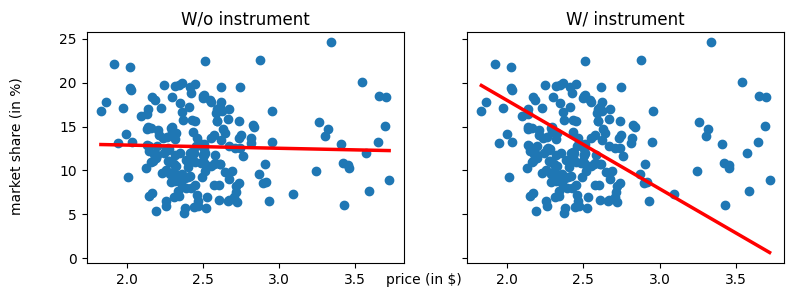

In [ ]:
figure, axis = plt.subplots(1, 2,sharex=True,sharey=True,figsize=(9,3))

axis[0].scatter(data[data['Häagen-Dazs'] == 0]['price'],data[data['Häagen-Dazs'] == 0]['s']*100)
b, a = np.polyfit(data[data['Häagen-Dazs'] == 0]['price'], data[data['Häagen-Dazs'] == 0]['s']*100, deg=1)
axis[0].plot(np.linspace(data[data['Häagen-Dazs'] == 0]['price'].min(), data[data['Häagen-Dazs'] == 0]['price'].max(), num=80), a + b * np.linspace(data[data['Häagen-Dazs'] == 0]['price'].min(), data[data['Häagen-Dazs'] == 0]['price'].max(), num=80), color="red", lw=2.5)
axis[0].set_title('W/o instrument')

axis[1].scatter(data[data['Häagen-Dazs'] == 0]['price'],data[data['Häagen-Dazs'] == 0]['s']*100)
a,b = IV2SLS(data[data['Häagen-Dazs'] == 0]['s']*100, sm.add_constant(data[data['Häagen-Dazs'] == 0]['price']), instrument = sm.add_constant(data[data['Häagen-Dazs'] == 0]['fuel cost'])).fit().params
axis[1].plot(np.linspace(data[data['Häagen-Dazs'] == 0]['price'].min(), data[data['Häagen-Dazs'] == 0]['price'].max(), num=80), a + b * np.linspace(data[data['Häagen-Dazs'] == 0]['price'].min(), data[data['Häagen-Dazs'] == 0]['price'].max(), num=80), color="red", lw=2.5)
axis[1].set_title('W/ instrument')

figure.text(0.5, 0.04, 'price (in $)', ha='center')
figure.text(0.04, 0.5, 'market share (in %)', va='center', rotation='vertical')
plt.show()

Can you explain why the line on the right is steeper?

Next, we re-estimate demand using the price of fuel to instrument the price of ice cream.

In [ ]:
twosls = IV2SLS(np.log(data['s']) - np.log(data['s0']), sm.add_constant(data[['price','Häagen-Dazs']]), instrument = sm.add_constant(data[['fuel cost','Häagen-Dazs']]))
twosls_result = twosls.fit()
const, alpha, beta = twosls_result.params.round(2)
twosls_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.462
Model:                         IV2SLS   Adj. R-squared:                  0.459
Method:                     Two Stage   F-statistic:                     231.0
                        Least Squares   Prob (F-statistic):           2.90e-67
Date:                Fri, 19 Jul 2024                                         
Time:                        14:41:59                                         
No. Observations:                 400                                         
Df Residuals:                     397                                         
Df Model:                           2                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0684      0.405      0.169      0.866      -0.727       0.864
price          -0.7899      0.160     -4.946      0.000      -1.104      -0.476
Häagen-Dazs    -1.1724      0.056    -20.757      0.000      -1.283      -1.061
==============================================================================
Omnibus:                        2.045   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                1.858
Skew:                           0.162   Prob(JB):                        0.395
Kurtosis:                       3.083   Cond. No.                         20.0
==============================================================================
"""

Compare the OLS and 2SLS price coefficients. Which one has a larger magnitude?

----

**Estimated Marginal Costs**

Based on our estimates, we can back out the marginal costs of Häagen-Dazs' and Ben \& Jerry's using the FOCs of their profit maximization problems.

In [ ]:
C_hat = (data.groupby(['Häagen-Dazs'])['price'].mean() + 1/(alpha*(1-data.groupby(['Häagen-Dazs'])['s'].mean()))).to_numpy()
print('The cost of supplying one unit of Häagen-Dazs ice-cream is', C_hat[0].round(2),'$.')
print('The cost of supplying one unit of Ben & Jerry\'s ice-cream is', C_hat[1].round(2),'$.')

The cost of supplying one unit of Häagen-Dazs ice-cream is 1.08 $.
The cost of supplying one unit of Ben & Jerry's ice-cream is 1.03 $.


**Counterfactual Equilibrium Computation**

Suppose we want to find out how much Häagen-Dazs's profit would change if sold ice cream as good as Ben \& Jerry's (i.e., if the Häagen-Dazs coefficient was zero) assuming its marginal cost did not change.

First, we calculate the variable profit using the data.

In [ ]:
pi_0 = ((data[data['Häagen-Dazs'] == 1]['sales'])*(data[data['Häagen-Dazs'] == 1]['price'] - C_hat[0])).sum()
print('Häagen-Dazs\'s variable profit in the current equilibrium are $',pi_0.astype(int),'.')

Häagen-Dazs's variable profit in the current equilibrium are $ 2351 .


To find the new prices (and market shares) we need to find the new Nash equilibrium. That is, we need to find the set of prices that satisfy firms' FOCs.

In [ ]:
def foc(P,C,params):
    const,alpha,beta = params
    return alpha*s(P,params)*(1-s(P,params))*(P-C) + s(P,params)


To calculate `foc` we have to write functions that calculate market shares (`s`) which in turn depend on the mean utilities (`V`).



In [ ]:
def s(P,params):
    return np.exp(V(P,params))/(1 + np.exp(V(P,params)))

def V(P,params):
    const,alpha,beta = params
    return const + alpha*np.array(P) + beta*np.array([0,1])

Let's use our 2SLS estimates (except that we set the Häagen-Dazs coefficient to zero) and the marginal costs that we have calculated to calculate the new prices `P_new`.

In [ ]:
res = optimize.root(foc,[0,0],args=(C_hat,[const,alpha,0]))
print('Root found?',res.success)
P_new = res.x
s_new = s(P_new,[const,alpha,0])
print('The new Häagen-Dazs unit price is $',round(P_new[0],2),', and the new Ben & Jerry\'s unit price is $',round(P_new[1],2),'.')
print('The new Häagen-Dazs market share is',round(100*s_new[0],0),'%. Ben & Jerry\'s market share is',100*round(s_new[1],2),'%.')

Root found? True
The new Häagen-Dazs unit price is $ 2.53 , and the new Ben & Jerry's unit price is $ 2.49 .
The new Häagen-Dazs market share is 13.0 %. Ben & Jerry's market share is 13.0 %.


We find that the prices and market shares of Häagen-Dazs and Ben & Jerry's are roughly the same. Can you explain why?

Next, we calculate Häagen-Dazs new (variable) profit.

In [ ]:
pi_1 = (data[data['Häagen-Dazs'] == 1]['county size']*s_new[0]*(P_new[0] - C_hat[0])).sum()
print('Häagen-Dazs\'s variable profit in the new equilibrium are $',pi_1.astype(int),'.')
print('Häagen-Dazs would benefit by $',(pi_1-pi_0).astype(int),' if its ice cream was as good as Ben \& Jerry\'s.')


Häagen-Dazs's variable profit in the new equilibrium are $ 7321 .
Häagen-Dazs would benefit by $ 4969  if its ice cream was as good as Ben \& Jerry's.
